# 2024 영화

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df = pd.read_csv('./data_movie/2024년 개봉작.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20231219,성수동 전시 : 디즈니100주년 기념 팝업 House of Wish & 디즈니 20...,성수동 전시 : 디즈니100주년 기념 팝업 House of Wish & 디즈니 <b...,성수동 전시 : 디즈니100주년 기념 팝업 House of Wish & 디즈니 20...
1,20240202,안녕하세요 죠로링입니다! 저는 19년도부터 넷플릭스를 구독하여 지금까지 친구들과 아...,"이유, <b>2024년<\/b> 개봉 예정작 저는 계정을 공유하고 있지만 넷플릭스를...",넷플릭스 계정 공유 방법 모바일 단속 시행 2024년 넷플 개봉작 추천
2,20240102,1월 개봉예정영화 2024년 최신 개봉작 한국 해외 외국 영화 추천 벌써 2일이 시...,1월 개봉예정영화 <b>2024년<\/b> 최신 <b>개봉작<\/b> 한국 해외 외...,1월 개봉예정영화 2024년 최신 개봉작 한국 해외 외국 영화 추천
3,20240205,오늘은 2024년 2월 메가박스 돌비시네마 개봉작에 관한 글을 적어볼까 합니다. 2...,<b>2024년<\/b> 2월 7일 돌비시네마 상영작은 아가일 <b>2024년<\/...,2024년 2월 메가박스 돌비시네마 개봉작 소개
4,20240501,이 포스팅은 2024년 5월 개봉 예정 영화 전체를 소개하는 소개글이 아닌 저 스스...,[<b>2024년<\/b> 5월 개봉 관람 예정 영화 리스트] 흥행 괴물 형사의 독...,[2024년 5월 개봉 관람 예정 영화 리스트] 흥행 괴물 형사의 독주를 막을 가정...


## 1. 전처리

In [3]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [4]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = [
'개봉작', '2024년', '영화', '개봉', '감독', '작품', '수익', '관객', '배우', '출연', '박스오피스',
'이야기', '관람', '한국', '흥행', '누적', '기록', '국내', '주연', '예정', '액션', '생각', '극장',
'시리즈', '상영', '연출', '사람', '연기', '시작', '드라마', '대비', '소개', '출처', '순위', '올해',
'정보', '공개', '개봉일', '최고', '신규', '추천', '후기', '출연진', '주차', '신작', '제목', '연속',
'리뷰', '순위', '상영', '줄거리', '평점', '결산', '정리', '돌파', '작품', '주말', '데히', '사랑',
'세계', '보이', '기대', '내용', '이후', '제작비', '가족', '장르', '모습', '영화제', '정도', '장면',
'주인공', '때문', '상황', '이름', '이미지', '기준', '구글', '이후', '원작', '오늘', '기대작', '주말',
'프로필', '예고편', '거리', '베스트', '시간표', '성적', '스포', '등극', '필모그래피', '최신', '역대', '결말',
'달러', '타임', '러닝', '대하', '파트', '주간', '매출', '진행', '제작', '극장판', '등급', 
'등장', '예상', '예매', '극장가', '기간', '단체', '경로', '할인', '관람료', '회원', '멤버', '안내',
'복지', '가운데', '공지', '주간', '리스트', '라인업', '파트'
]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = 'stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [5]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [6]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 31.5 s
Wall time: 1min 52s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20231219,성수동 전시 디즈니100주년 기념 팝업 House of Wish 디즈니 2024년 ...,성수동 전시 디즈니100주년 기념 팝업 House of Wish 디즈니 b2024년...,성수동 전시 디즈니100주년 기념 팝업 House of Wish 디즈니 2024년 ...,성수동 전시 디즈니 주년 기념 팝업 디즈니 위시 블로거 새틴 인플루언서새틴 일요일 ...,성수동 전시 디즈니 주년 기념 팝업 디즈니 위 시 블로거 새틴 토 수 운영 디즈니 ...,성수동 전시 디즈니 주년 기념 팝업 디즈니 위시
1,20240202,안녕하세요 죠로링입니다 저는 19년도부터 넷플릭스를 구독하여 지금까지 친구들과 아이...,이유 b2024년b 개봉 예정작 저는 계정을 공유하고 있지만 넷플릭스를 잘 보지 않...,넷플릭스 계정 공유 방법 모바일 단속 시행 2024년 넷플 개봉작 추천,안녕하세요 죠로링 년도 넷플릭스 구독 친구 아이디 공유 사용 작년 넷플릭스 금액 인...,이유 계정 공유 넷플릭스 데 넷플릭스 코리아 인스타 주,넷플릭스 계정 공유 방법 모바일 단속 시행 넷플
2,20240102,1월 개봉예정영화 2024년 최신 개봉작 한국 해외 외국 영화 추천 벌써 2일이 시...,1월 개봉예정영화 b2024년b 최신 b개봉작b 한국 해외 외국 영화 추천 벌써 2...,1월 개봉예정영화 2024년 최신 개봉작 한국 해외 외국 영화 추천,해외 외국 도 느낌 느낌 데 작년 도 내일 디즈니 위시 글 포스팅 번 김 체크 길 ...,해외 외국 도 느낌 느낌 데 작년 도,해외 외국
3,20240205,오늘은 2024년 2월 메가박스 돌비시네마 개봉작에 관한 글을 적어볼까 합니다 2월...,b2024년b 2월 7일 돌비시네마 상영작은 아가일 b2024년b 2월 7일 b개봉...,2024년 2월 메가박스 돌비시네마 개봉작 소개,은 메가박스 돌비 시네마 적 돌비 은 패스 애매 적 아이맥스 돌비 시네마 은 초 말...,돌비 시네마 상영작 아가 아가 은 돌비 시네마 포맷 가일 돌비 비전 돌비 애트모스 ...,메가박스 돌비 시네마
4,20240501,이 포스팅은 2024년 5월 개봉 예정 영화 전체를 소개하는 소개글이 아닌 저 스스...,b2024년b 5월 개봉 관람 예정 영화 리스트 흥행 괴물 형사의 독주를 막을 가정...,2024년 5월 개봉 관람 예정 영화 리스트 흥행 괴물 형사의 독주를 막을 가정의 ...,포스팅 전체 글 고민 목표 자체 고민 인하 개인 취향 선정 만 괴물 형사 독주 가정...,괴물 형사 독주 가정 달 승자 길 비수기 성수기 진입 가정 달 니,괴물 형사 독주 가정 달 승자


In [7]:
# 전처리한 결과 csv로 저장 
df.to_csv('24영화_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [8]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [9]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [10]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
5686,북미,771
8427,애니메이션,586
14202,파묘,517
9854,웡카,481
5274,범죄도시,454
9832,월드,404
3009,디즈니,360
1978,넷플릭스,334
15261,해외,319
13419,쿵푸,292


### [preprocessed_description]

In [11]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [12]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
1884,파묘,56
302,넷플릭스,36
1307,웡카,35
1126,애니메이션,28
452,디즈니,27
719,범죄도시,26
1267,외계인,25
769,북미,22
1269,외국,19
1484,장애인,18


### [preprocessed_title]

In [13]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [14]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
862,파묘,35
314,북미,35
625,웡카,29
290,범죄도시,28
105,넷플릭스,23
174,디즈니,18
473,씨네아트리,17
166,동원,16
595,외계인,14
878,팬더,12


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [15]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [16]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'북미': 771,
 '애니메이션': 586,
 '파묘': 517,
 '웡카': 481,
 '범죄도시': 454,
 '월드': 404,
 '디즈니': 360,
 '넷플릭스': 334,
 '해외': 319,
 '쿵푸': 292,
 '범죄': 291,
 '시네마': 279,
 '팬더': 279,
 '일본': 271,
 '외계인': 271,
 '미국': 269,
 '공포': 245,
 '아카데미': 240,
 '평가': 231,
 '캐릭터': 228,
 '연휴': 225,
 '시대': 223,
 '기자': 222,
 '사건': 221,
 '친구': 217,
 '서울': 215,
 '돌비': 214,
 '오브': 213,
 '주요': 213,
 '성공': 208,
 '티모시': 208,
 '좌석': 207,
 '전체': 206,
 '코미디': 198,
 '시민': 195,
 '샬라메': 195,
 '마지막': 195,
 '데이즈': 194,
 '인간': 194,
 '자리': 193,
 '덕희': 190,
 '스토리': 189,
 '시즌': 185,
 '인생': 184,
 '포스터': 180,
 '스크린': 178,
 '마동석': 175,
 '혹성탈출': 174,
 '전쟁': 174,
 '고질라': 174,
 '독립': 174,
 '지난주': 172,
 '세상': 169,
 '금주': 168,
 '판매': 167,
 '느낌': 164,
 '손익': 163,
 '도시': 163,
 '오컬트': 163,
 '가능': 163,
 '분기점': 162,
 '점유': 162,
 '개인': 160,
 '무비': 160,
 '시청': 159,
 '소풍': 159,
 '비밀': 158,
 '인하': 157,
 '오멘': 157,
 '차지': 157,
 '인기': 157,
 '부대': 156,
 '전주': 156,
 '오리지널': 156,
 '다양': 155,
 '스턴트맨': 154,
 '칼날': 154,
 '데드': 153,
 '시장': 152,
 '도그': 152,
 '토마토': 

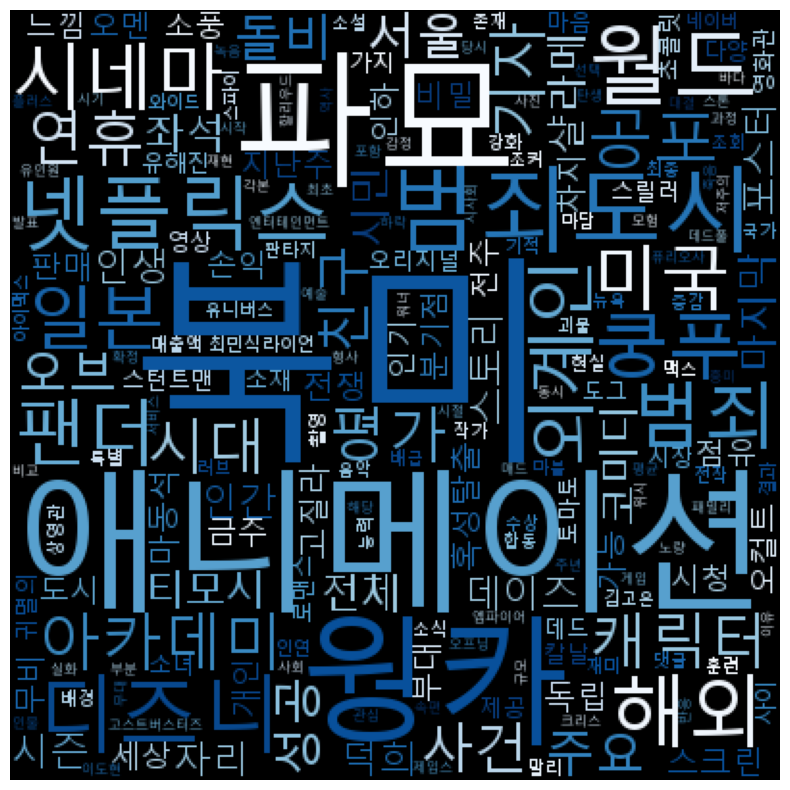

In [17]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

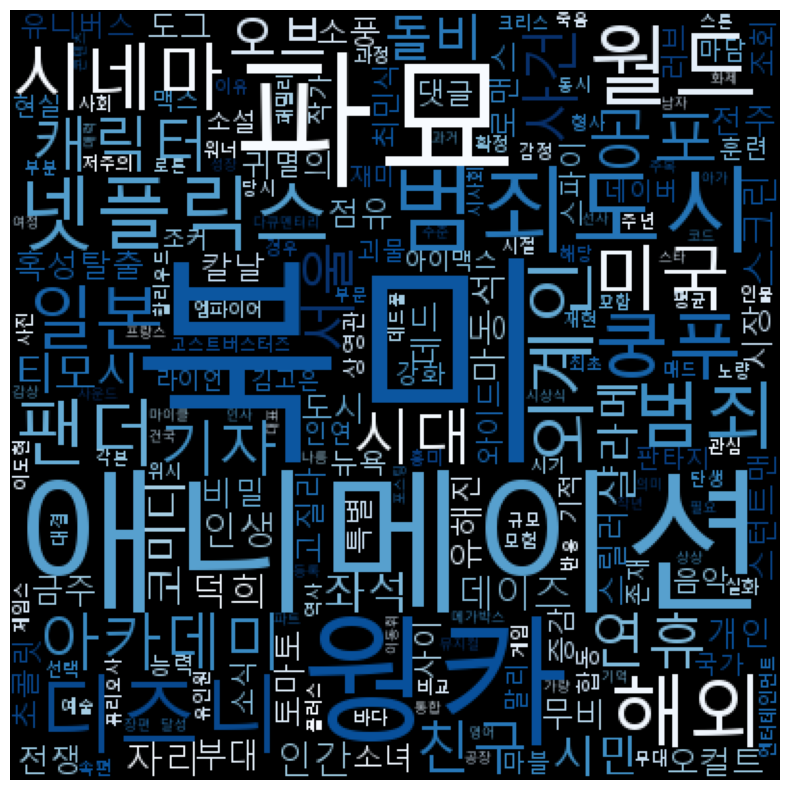

In [21]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'느낌', '오멘', '마음', '영화관', '독립', '주요', '성공' ,'시즌', '배경', '판매',
             '영상', '손익', '마지막', '포스터', '결과', '시청', '전작', '가능', '발표', '소재',
             '지난주', '가지', '스토리', '오리지널', '다양', '인하', '인기', '전체', '촬영',
             '배급', '상태', '차지', '녹음', '최종', '하락', '수상', '평가', '분기점', '매출액',
             '서비스', '시작', '오프닝', '제공', '세상'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [22]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'파묘': 56,
 '넷플릭스': 36,
 '웡카': 35,
 '애니메이션': 28,
 '디즈니': 27,
 '범죄도시': 26,
 '외계인': 25,
 '북미': 22,
 '외국': 19,
 '장애인': 18,
 '군인': 17,
 '학생': 17,
 '연휴': 16,
 '새해': 16,
 '데이즈': 16,
 '위시': 15,
 '공포': 15,
 '도그': 14,
 '오컬트': 14,
 '팬더': 13,
 '마블': 13,
 '최초': 13,
 '성공': 13,
 '사진': 13,
 '스턴트맨': 13,
 '시기': 12,
 '쿵푸': 12,
 '주요': 11,
 '미국': 11,
 '영화관': 11,
 '개인': 11,
 '시대': 11,
 '파업': 11,
 '일본': 11,
 '해외': 11,
 '혹성탈출': 10,
 '동원': 10,
 '압도': 10,
 '오프닝': 10,
 '네이버': 10,
 '아가': 10,
 '포스터': 10,
 '시민': 10,
 '달성': 10,
 '소풍': 10,
 '다양': 9,
 '시즌': 9,
 '전체': 9,
 '인사이드': 9,
 '코리아': 9,
 '소식': 9,
 '아웃': 9,
 '초콜릿': 9,
 '돌비': 8,
 '티모시': 8,
 '스코어': 8,
 '공장': 8,
 '관심': 8,
 '시네마': 8,
 '확정': 8,
 '아카데미': 8,
 '갑진': 8,
 '오멘': 8,
 '마지막': 8,
 '인기': 8,
 '범죄': 8,
 '덕희': 8,
 '영상': 8,
 '오브': 8,
 '서울': 8,
 '워너': 8,
 '랜드': 7,
 '라이언': 7,
 '샬라메': 7,
 '작년': 7,
 '금일': 7,
 '금주': 7,
 '데드': 7,
 '속도': 7,
 '손익': 7,
 '조커': 7,
 '수요일': 7,
 '스튜디오': 7,
 '표시': 7,
 '사이': 7,
 '입장': 7,
 '찰리와': 7,
 '월드': 7,
 '오리지널': 7,
 '고질라': 7,
 '분기점': 7,
 '브라더

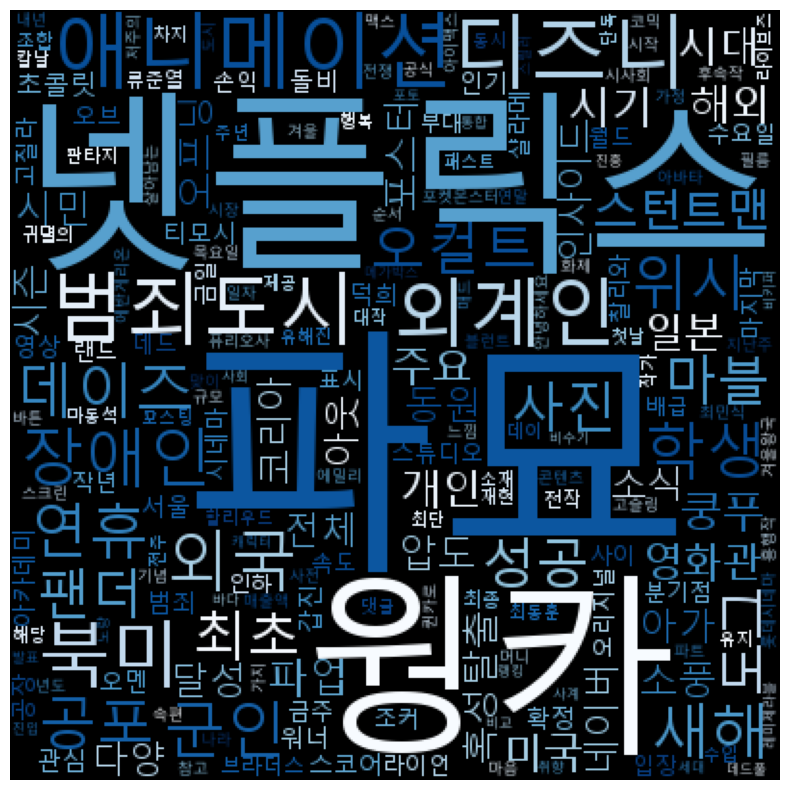

In [23]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

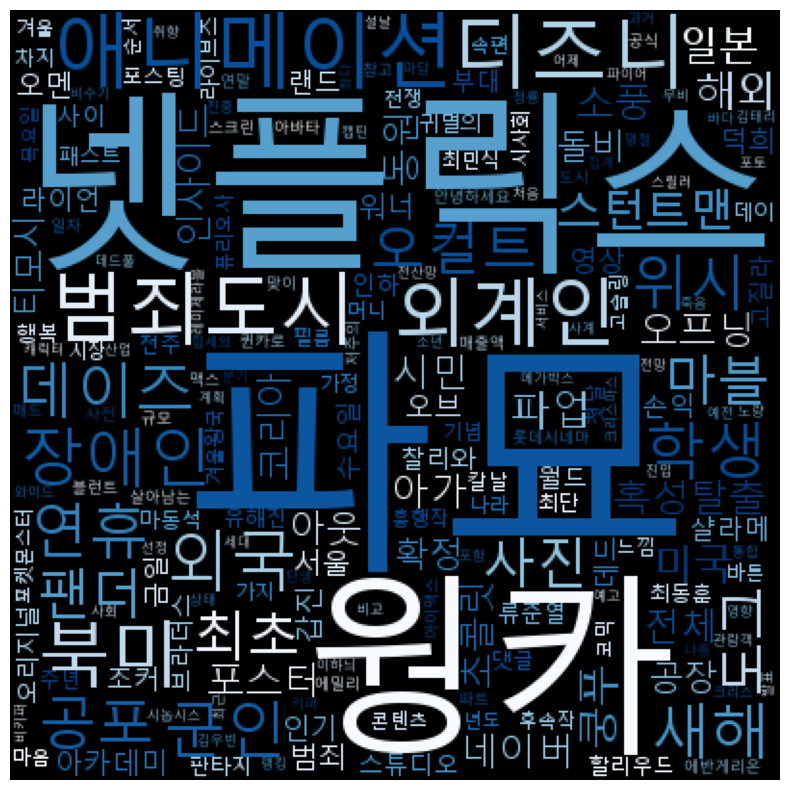

In [25]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'내년', '조합', '다양', '관심', '스코어', '성공', '개인', '압도',' 최단',
             '소재', '재현', '마지막', '시대', '시기', '분기점', '영화관', '소식', '대작',
            '주요', '시즌', '작년', '시네마', '표시', '달성', '금주', '전작', '해당', '작가',
            '속도', '배급', '제공', '유지', '화제', '최종', '단독', '수입', '입장', '동시',
            '시청', '시작', '지난주'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [26]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'파묘': 35,
 '북미': 35,
 '웡카': 29,
 '범죄도시': 28,
 '넷플릭스': 23,
 '디즈니': 18,
 '씨네아트리': 17,
 '동원': 16,
 '외계인': 14,
 '팬더': 12,
 '쿵푸': 12,
 '위시': 11,
 '혹성탈출': 11,
 '시네마': 11,
 '오컬트': 9,
 '범죄': 9,
 '월드': 9,
 '말리': 8,
 '덕희': 8,
 '연휴': 8,
 '시민': 8,
 '러브': 8,
 '돌비': 7,
 '도시': 7,
 '주년': 7,
 '시사회': 7,
 '애니메이션': 7,
 '확정': 7,
 '쿠키': 6,
 '도그': 6,
 '칼날': 6,
 '댓글': 6,
 '귀멸의': 6,
 '분기점': 6,
 '스턴트맨': 6,
 '데이즈': 6,
 '조커': 6,
 '메가박스': 6,
 '전쟁': 6,
 '부대': 6,
 '파트': 6,
 '손익': 6,
 '공포': 6,
 '해외': 6,
 '건국': 6,
 '아웃': 5,
 '달성': 5,
 '시대': 5,
 '아가': 5,
 '인연': 5,
 '인사이드': 5,
 '포스터': 5,
 '무대': 5,
 '인사': 5,
 '마담': 5,
 '마음': 5,
 '애니': 5,
 '랜드': 5,
 '오멘': 5,
 '원더랜드': 5,
 '영화': 5,
 '오브': 5,
 '영어': 4,
 '어린이': 4,
 '이주': 4,
 '롯데시네마': 4,
 '예고': 4,
 '합동': 4,
 '차기': 4,
 '강화': 4,
 '마블': 4,
 '존재': 4,
 '속도': 4,
 '원더': 4,
 '괴물': 4,
 '질주': 4,
 '마동석': 4,
 '시기': 4,
 '스코어': 4,
 '기적': 4,
 '예측': 4,
 '훈련': 4,
 '비키퍼': 4,
 '매드': 4,
 '고질라': 4,
 '아이맥스': 4,
 '맥스': 4,
 '스릴러': 3,
 '베테랑': 3,
 '지방': 3,
 '형사': 3,
 '모음': 3,
 '미국': 3,
 '상승세': 3,
 '성공

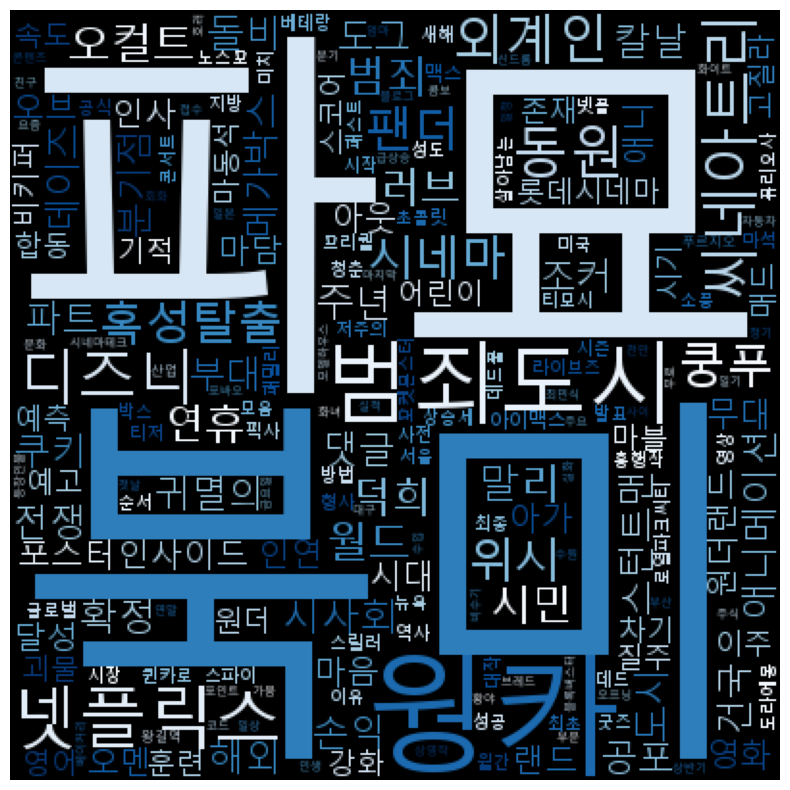

In [27]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

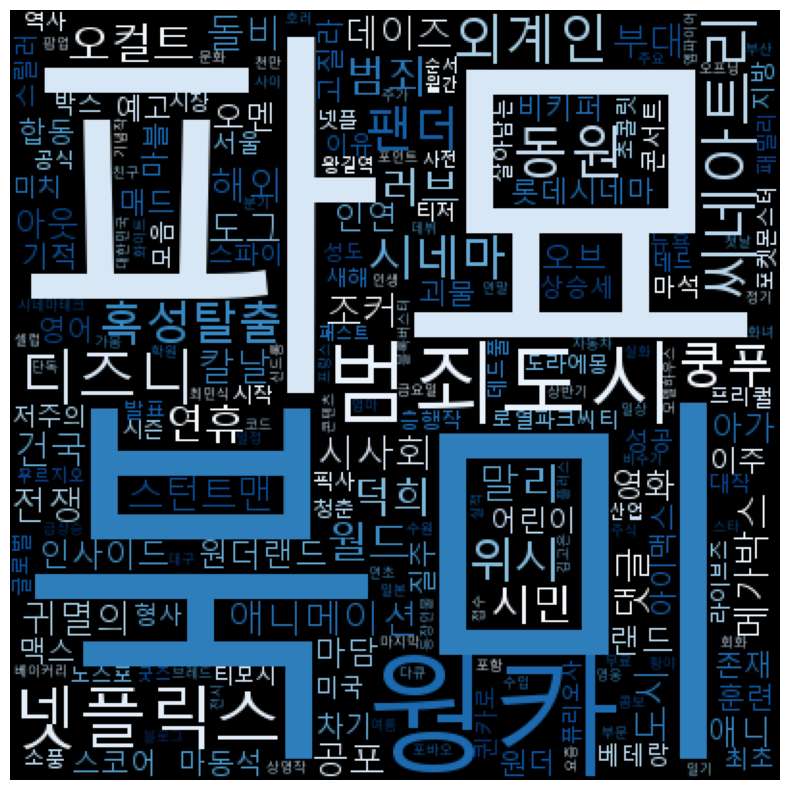

In [29]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'속도', '주년', '쿠키', '예측', '달성', '확정', '손익', '강화', '마음',
        '영상', '무대', '시기', '분기점', '인사', '파트', '포스터', '방법', '시사회'
        '이유','시대', '최종'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기